In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import torch
from torchvision import models, transforms
import torch.nn.functional as F
from tensorflow.keras.applications.imagenet_utils import decode_predictions 
from lime import lime_image
from scipy import ndimage 

In [4]:
# Function to load a test image
def load_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 

In [5]:
# Function to decode an imagenet class index to its name
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

In [6]:
# Load the pretrained model for Resnet50 available in Pytorch.
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.eval();

In [7]:
# We need to convert images to Pytorch tensors, resize and normalize them to match the input expected by our pretrained model.
pre_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256), antialias=True),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])  

In [8]:
# Now we are ready to define the prediction function that Lime needs. 
# The input to this function is a numpy array of images where each image is a numpy array of shape (channel, height, width). 
# The output is a numpy array of shape (image index, classes) where each value is the probability of an image-class combination.
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(pre_transforms(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


# Function to extract an image patch
def extract_patch(image, mask):
    bg = np.mean(image.mean(axis=0).mean(axis=0))
    mask_expanded = np.expand_dims(mask, -1)
    patch = (mask_expanded * image + (1 - mask_expanded) * float(bg))/255
    return patch

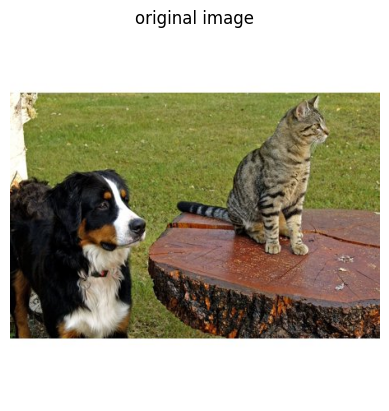

In [9]:
# Let's see the original image
img = load_image('images/dogs.png')
plt.imshow(img)
plt.title('original image')
plt.axis('off')
plt.show()

In [10]:
# Lime produces the array of images from original input image by pertubation algorithm. 
# So we need to provide two things: (1) original image as numpy array (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output. 
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    np.array(img), 
    batch_predict, # classification function
    top_labels=1, # how many top predictions we want to explain
    hide_color=0, 
    num_samples=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

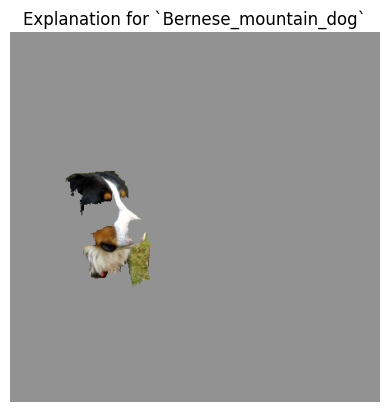

In [12]:
# Let's apply the explanation mask on the image to see the areas that are encouraging the top prediction(s).
for i, class_idx in enumerate(explanation.top_labels):
    temp, mask = explanation.get_image_and_mask(class_idx, positive_only=True, num_features=5, hide_rest=False)
    label_im, nb_labels = ndimage.label(mask) 
    plt.imshow(extract_patch(temp, mask))
    plt.title(f'Explanation for `{class_name(class_idx)}`')
    plt.axis('off')
    plt.show()